In [15]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import json
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
from ortools.sat.python import cp_model
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm

In [16]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, pathes, v_len=64, h_len=16, f_dim=118):
        self.pathes = pathes
        self.f_dim = f_dim
        self.v_len = v_len
        self.h_len = h_len

    def __len__(self):
        return len(self.pathes)

    def __getitem__(self, idx):

        with open(self.pathes[idx], 'r', encoding='utf-8') as file:
            data = json.load(file)

        rand_count_view = np.random.randint(len(data['v'])//2, len(data['v'])+1)
        rand_views_list = sorted(random.sample(list(range(len(data['v']))), rand_count_view))
        rand_house_fitr = torch.rand(data['n'], self.f_dim)
        
        padded = self.v_len-rand_count_view
        n_houses = torch.tensor(data['t']).shape[1]
        views_masks = torch.tensor([True]*rand_count_view+[False]*padded)
        house_masks = []
        house_fites = []
        for view_idx in rand_views_list:
            houses_f = []
            h_c = len(data['b'][view_idx])
            house_mask = torch.tensor([True]*h_c + [False]*(self.h_len-h_c))
            
            house_fitr = []
            for house in torch.tensor(data['b'][view_idx]):
                house_idx = int(house[0])
                noise_house_f = rand_house_fitr[house_idx]# + torch.randn(self.f_dim) * 0.5
                fully_house_f = torch.cat([house[1:], noise_house_f])
                house_fitr.append(fully_house_f)
            posfix = torch.full((self.h_len-len(data['b'][view_idx]), self.f_dim+4),-150.)
            house_fitr = torch.cat([torch.stack(house_fitr), posfix], dim=0)
            house_fites.append(house_fitr)
            house_masks.append(house_mask)

        postfix = torch.full((padded, self.h_len), False)
        house_masks = torch.cat([torch.stack(house_masks), postfix], dim=0)
        postfix = torch.full((padded, self.h_len, self.f_dim+4), -250.)
        house_fites = torch.cat([torch.stack(house_fites), postfix], dim=0)

        camera_real = torch.tensor(data['c'])[rand_views_list][:, rand_views_list]
        target_real = torch.tensor(data['t'])[rand_views_list]

        camera = torch.full((self.v_len, self.v_len, 2), -75.)
        camera_idx = torch.cartesian_prod(torch.tensor(rand_views_list), torch.tensor(rand_views_list))
        camera[camera_idx[:, 0], camera_idx[:, 1]] = camera_real.view(-1, 2)

        target = torch.full((self.v_len, self.h_len, 4), -95.)
        target[views_masks, :n_houses, :] = target_real[:,:,1:]

        # target_masks -- views_masks, :n_houses, :
        return house_fites, views_masks, house_masks, camera, target, n_houses

In [4]:
path = ...
pathes = [path + '/' + i for i in os.listdir(path)]
dataset = Dataset(pathes)
house_fites, views_masks, house_masks, camera_target, bbox_target, house_count = dataset[0]

In [22]:
cannot_link = []
features = []
coords = []
views = []
i = 0
for view in range(house_fites[views_masks].shape[0]):
    real_houses = house_fites[views_masks][view][house_masks[views_masks][view]]
    cl = []
    for house in real_houses:
        coords += [house[:4]]
        features += [house[4:]]
        cl.append(i)
        views.append(view)
        i += 1
    if len(cl) >1:
        cannot_link += [cl]

views = np.array(views)
coords = np.array(coords)
X = torch.stack(features).numpy()

In [128]:
def custom_cluster_with_constraints(X, cannot_link_groups, eps):
    N = len(X)
    labels = [-1] * N  # -1 — ещё не кластеризованы
    cluster_centers = []  # индексы точек-центров
    clusters = []  # список списков: индексы точек в каждом кластере
    current_label = 0

    # Собираем запретные пары
    cannot_link_pairs = set()
    for group in cannot_link_groups:
        for i in group:
            for j in group:
                if i != j:
                    cannot_link_pairs.add(tuple(sorted((i, j))))

    for i in tqdm(range(N)):
        assigned = False
        xi = X[i]

        for idx, center_idx in enumerate(cluster_centers):
            center = X[center_idx]
            distance = np.linalg.norm(xi - center)

            if distance <= eps:
                # Проверка: не нарушаем ли cannot-link?
                cluster = clusters[idx]
                violates = any(tuple(sorted((i, j))) in cannot_link_pairs for j in cluster)

                if not violates:
                    clusters[idx].append(i)
                    labels[i] = idx
                    assigned = True
                    break

        if not assigned:
            # Создаём новый кластер с этой точкой как центром
            cluster_centers.append(i)
            clusters.append([i])
            labels[i] = current_label
            current_label += 1

    return labels

def orient(view_labels_1, view_labels_2, coords_1, coords_2):
    x_labels = list(set(view_labels_1)&set(view_labels_2))
    f_mask = np.array([True if i in x_labels else False for i in sorted(view_labels_1)])
    s_mask = np.array([True if i in x_labels else False for i in sorted(view_labels_2)])
    sorted_f = np.array([p for _, p in sorted(zip(view_labels_1, coords_1))])
    real_f = sorted_f[f_mask]
    sorted_s = np.array([p for _, p in sorted(zip(view_labels_2, coords_2))])
    real_s = sorted_s[s_mask]
    params = find_best_transform(real_f, real_s)
    transformed_s = apply_transform(sorted_s, params)
    point_dict = {i: [] for i in sorted(view_labels_2)}
    for i in range(len(view_labels_2)):
        lab = sorted(view_labels_2)[i]
        point_dict[lab] += [transformed_s[i]]
    return params, point_dict

def from_great(great_dict):
    labels = []
    coords = []
    for k, i in great_dict.items():
        if len(i) > 0:
            labels += [k]
            lab_points = np.stack(i)
            mean_point = lab_points.mean(axis=0)
            coords += [mean_point]
    coords = np.stack(coords)
    return labels, coords

def add_great(great_dict, s_dict):
    for k, i in s_dict.items():
        great_dict[k] += i

def rotate_points(points, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    R = np.array([[c, -s], [s, c]])
    return points @ R.T

def find_best_transform(ref_points, target_points, s=True):
    angles = [0, 90, 180, 270]
    best_error = np.inf
    best_transformed = None
    best_params = None
    for angle in angles:
        rotated = rotate_points(target_points, angle)
        n_p = len(ref_points)
        a = np.std(ref_points) / np.std(rotated)
        scale = 1#(-1/(n_p-1)+1)*(a-1)+1
        shift = ref_points.mean(axis=0) - rotated.mean(axis=0) * scale
        transformed = rotated * scale + shift
        error = np.linalg.norm(ref_points - transformed)
        if error < best_error:
            best_error = error
            best_transformed = transformed
            best_params = (angle, scale, shift)

    return best_params

def apply_transform(points, params):
    angle, scale, shift = params
    rotated = rotate_points(points, angle)
    transformed = rotated * scale + shift
    return transformed

In [9]:
labels = custom_cluster_with_constraints(X, cannot_link, eps=1)

  0%|          | 0/171 [00:00<?, ?it/s]

In [129]:
view_count = views_masks.sum().item()
view_labels = [[] for _ in range(view_count)]
for v, l in zip(views, labels):
    view_labels[v] += [l]

# Определение вида с набольшим количеством домов
great_view = -1
max_count = -1
for i, j in enumerate(cannot_link):
    if len(j) > max_count:
        max_count = len(j)
        great_view = i

# Список заюранных видов
yet = [great_view]

# Итговый список параметров видов
view_params = [None for _ in range(view_count)]
view_params[great_view] = (0, 0, np.array([0, 0]))

great_dict = {i: [] for i in sorted(list(set(labels)))}
for i in range(len(view_labels[great_view])):
    lab = view_labels[great_view][i]
    great_dict[lab] += [coords[views == great_view][:, :2][i]]

  0%|          | 0/100000 [00:00<?, ?it/s]

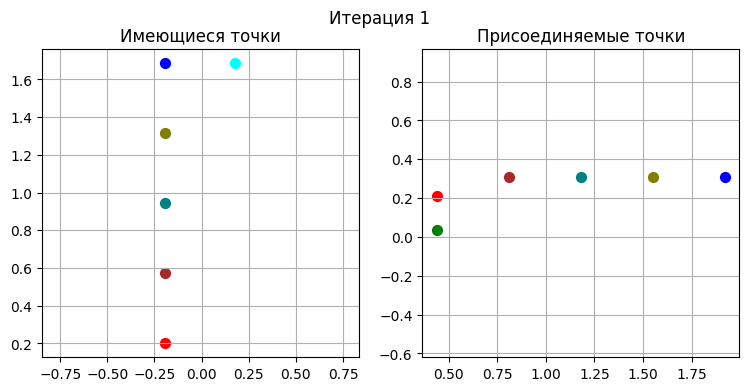

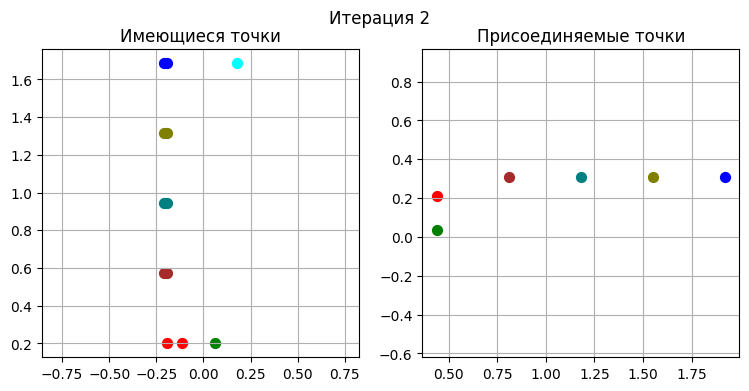

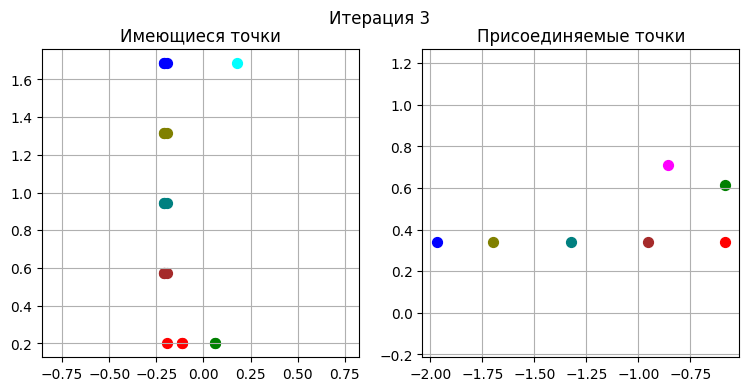

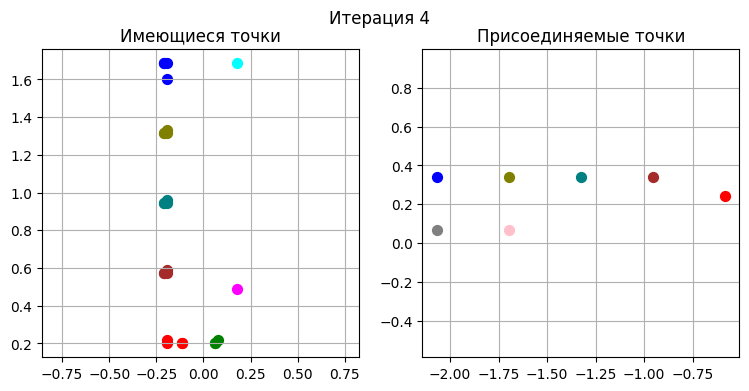

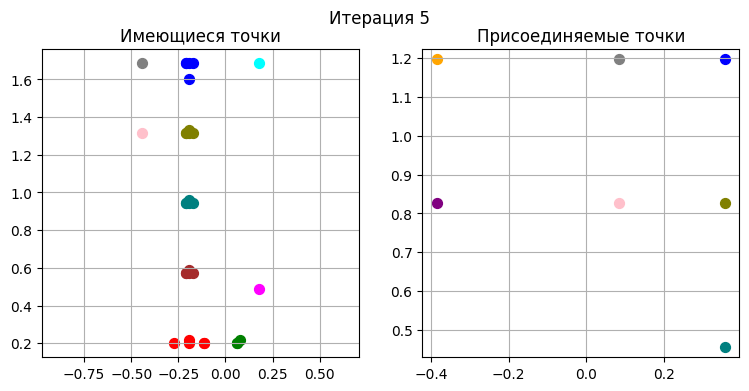

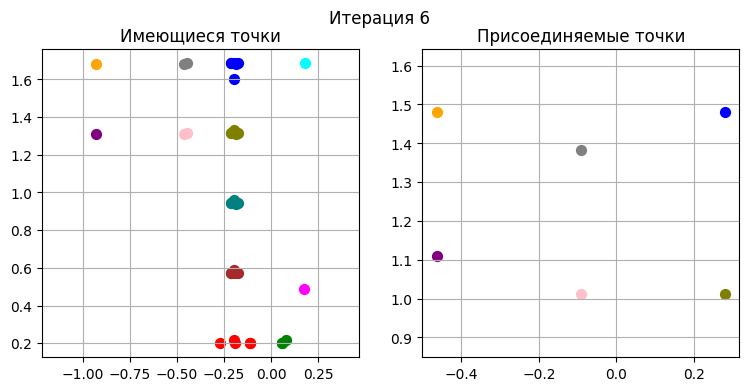

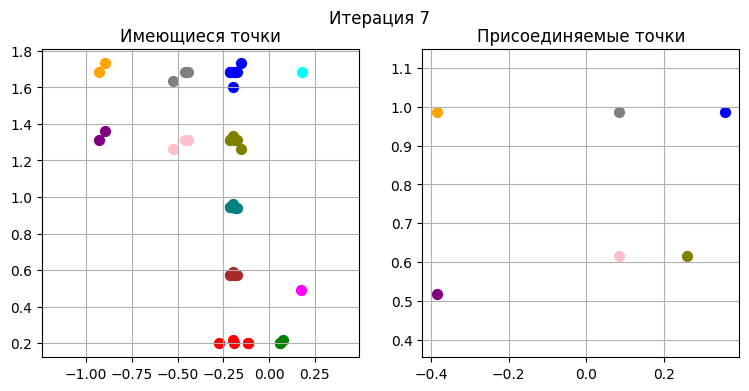

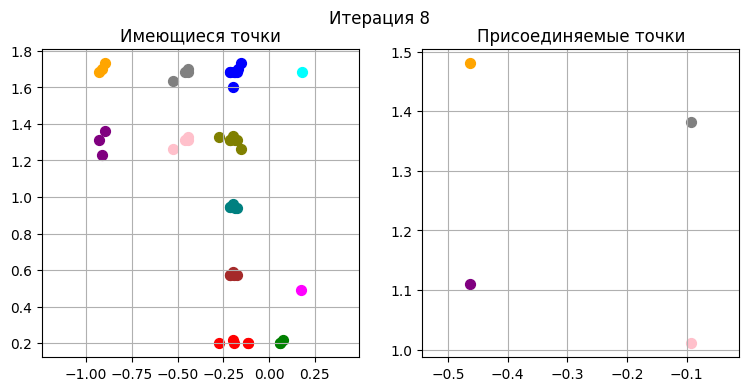

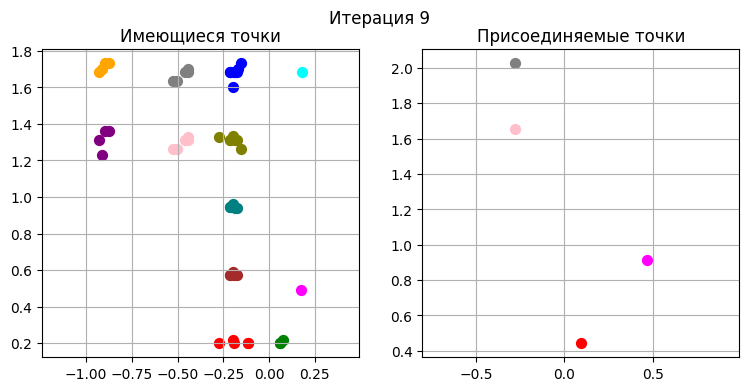

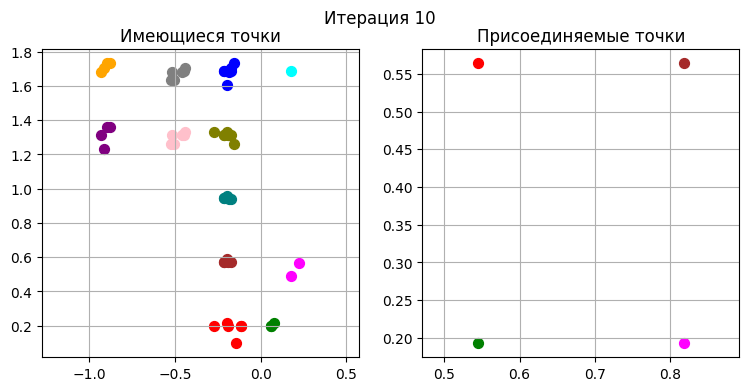

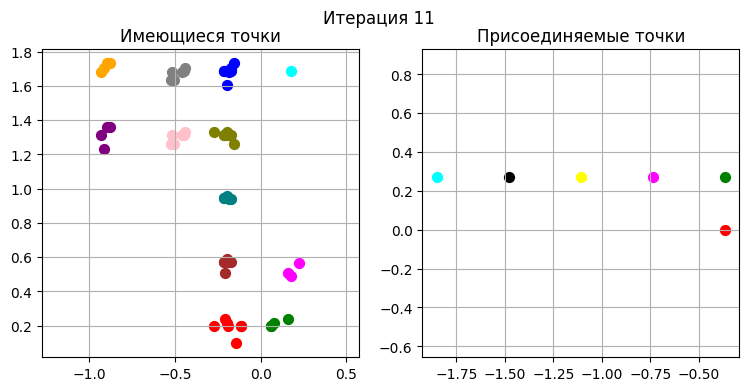

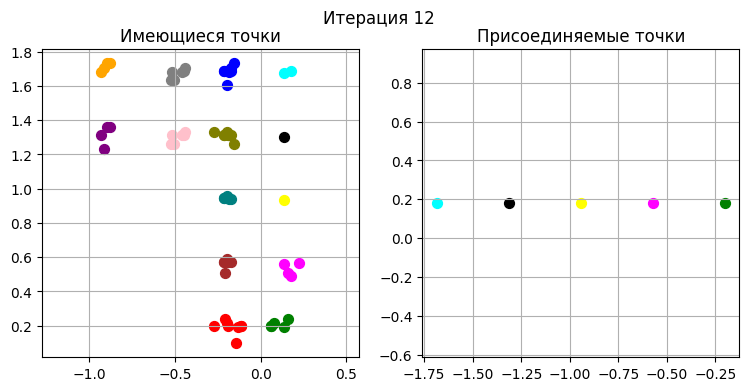

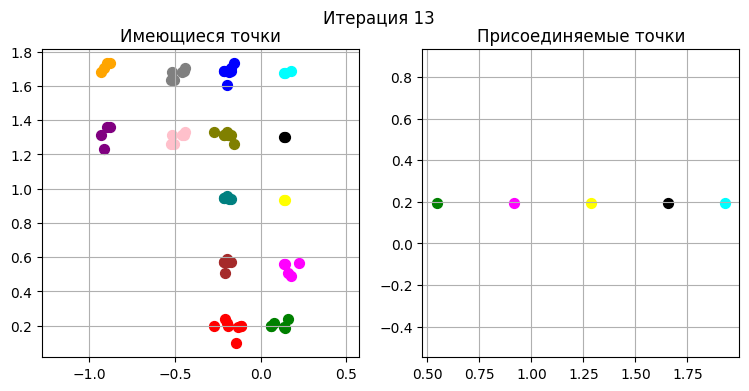

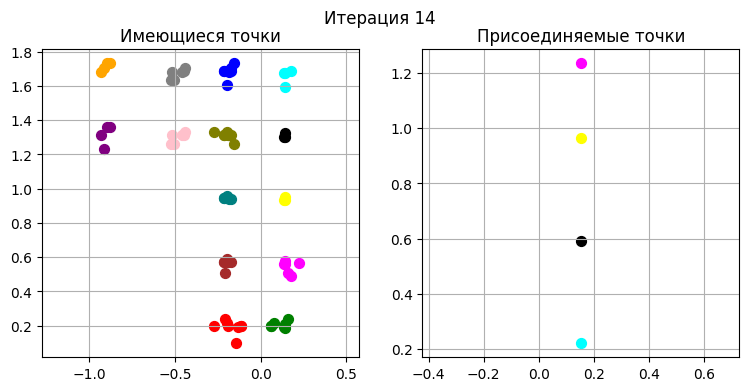

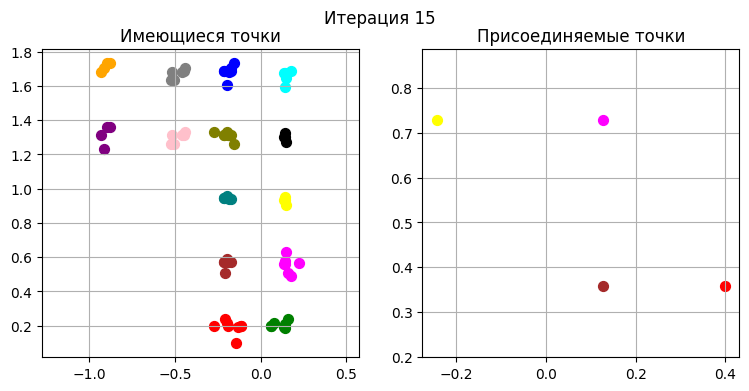

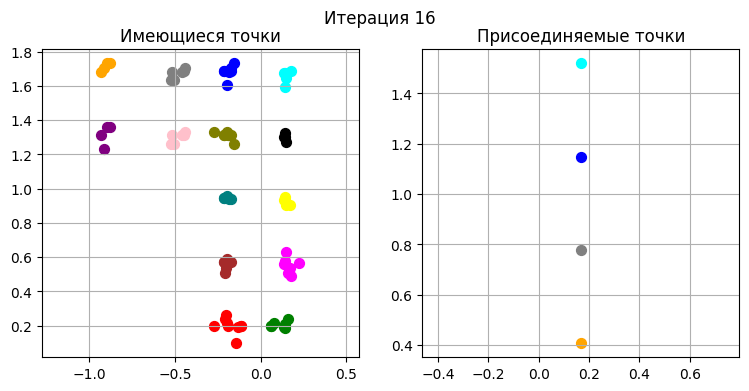

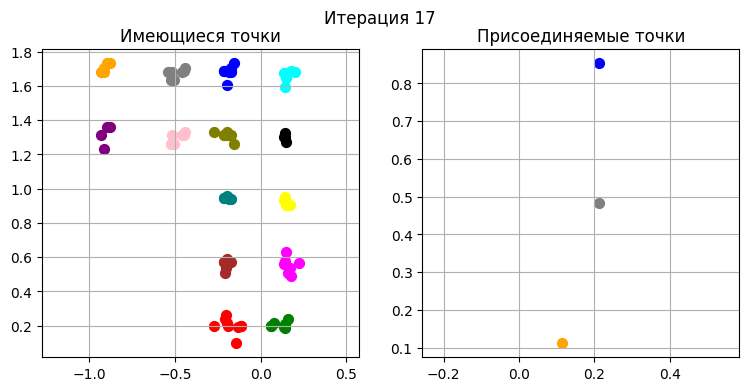

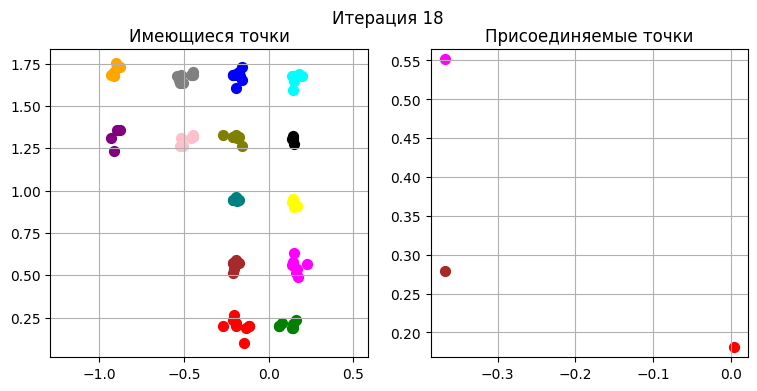

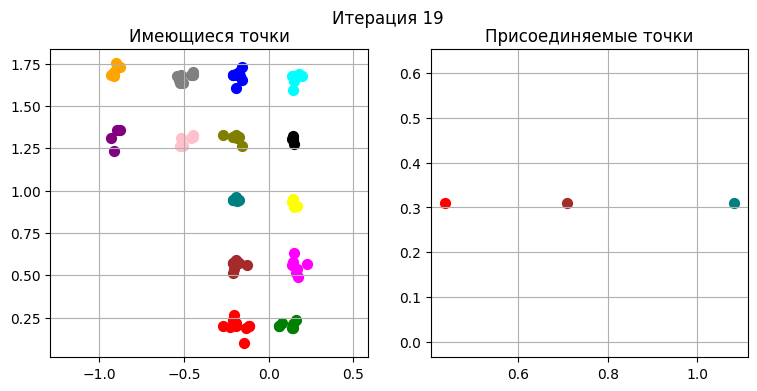

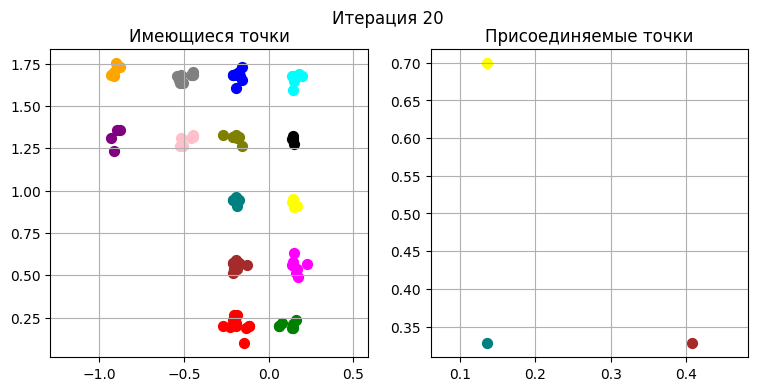

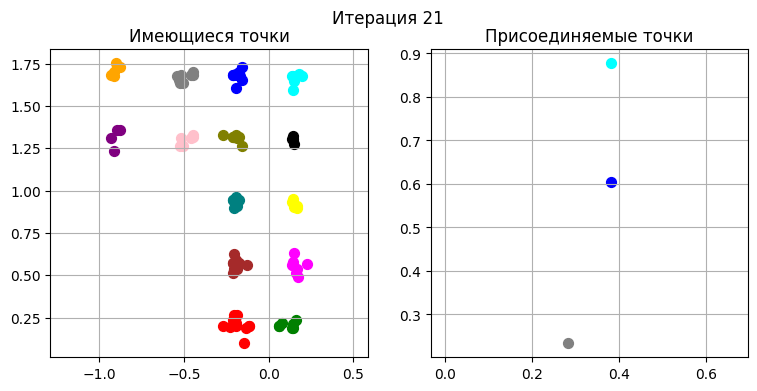

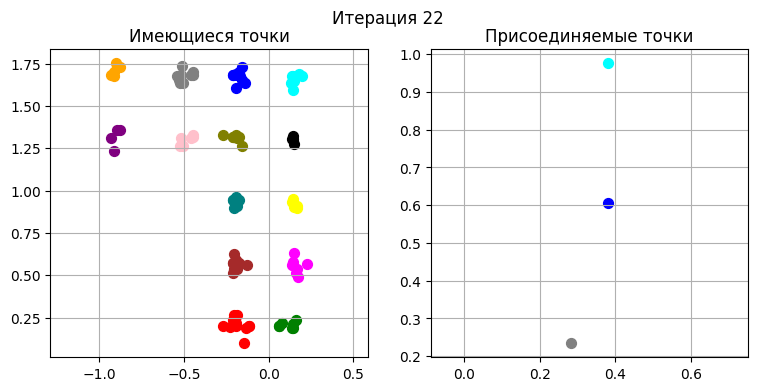

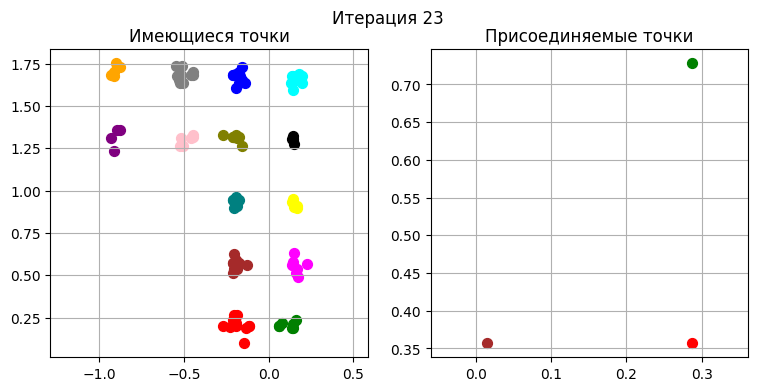

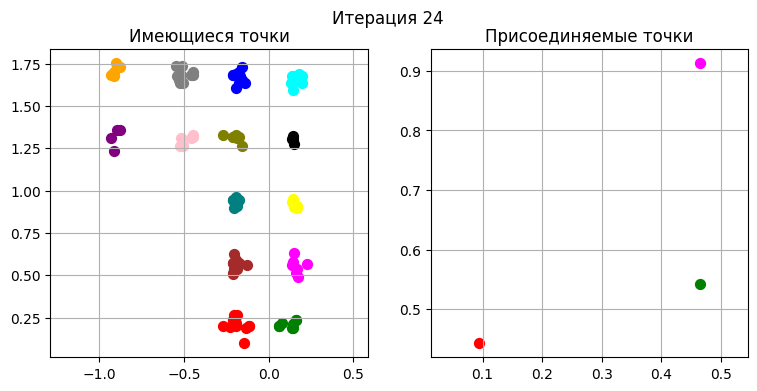

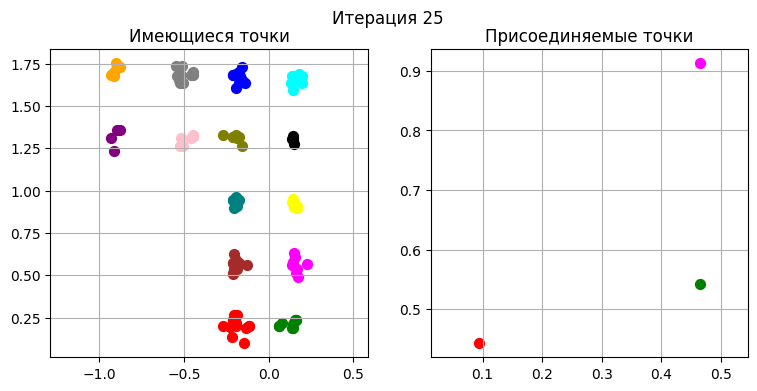

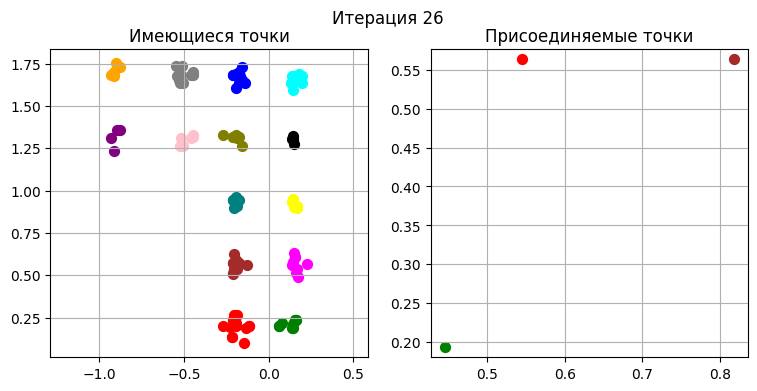

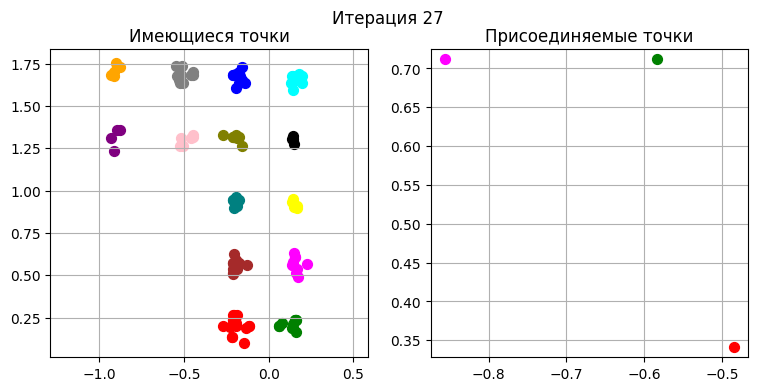

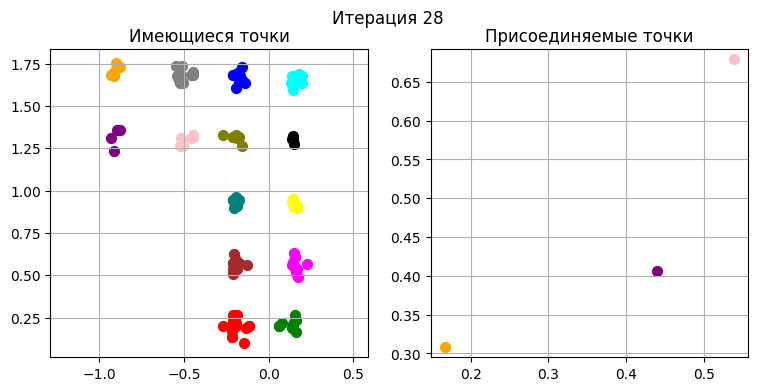

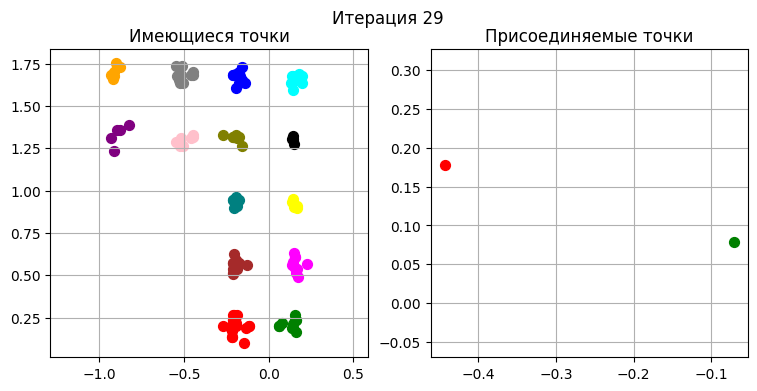

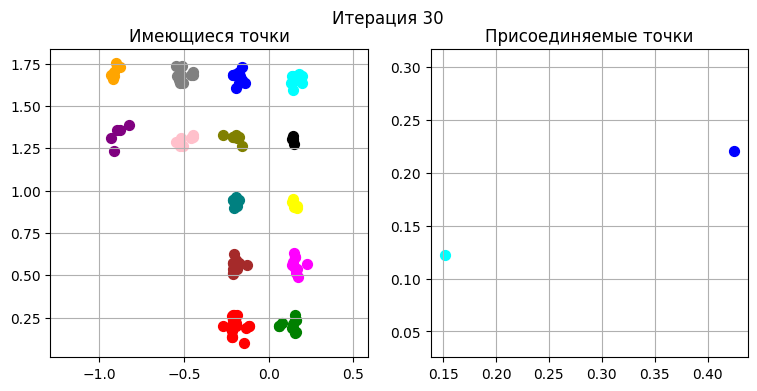

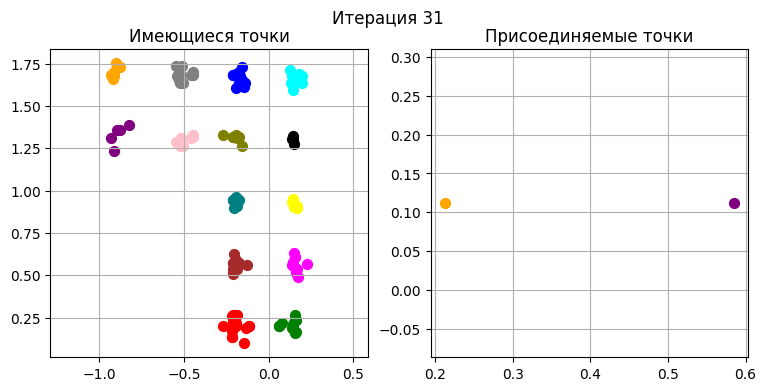

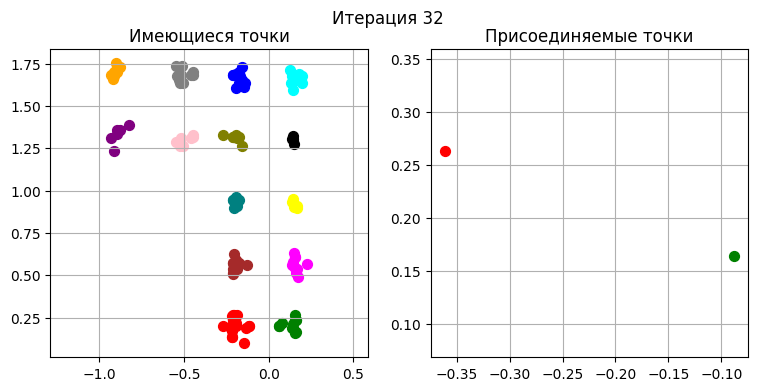

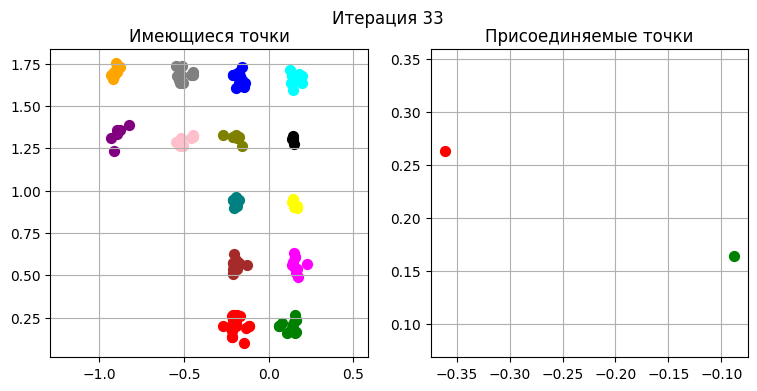

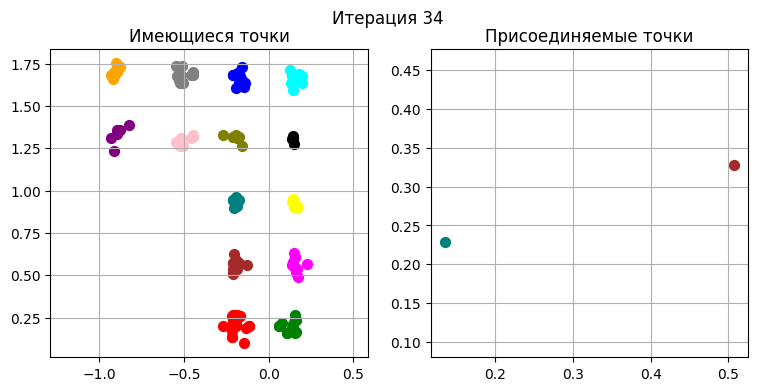

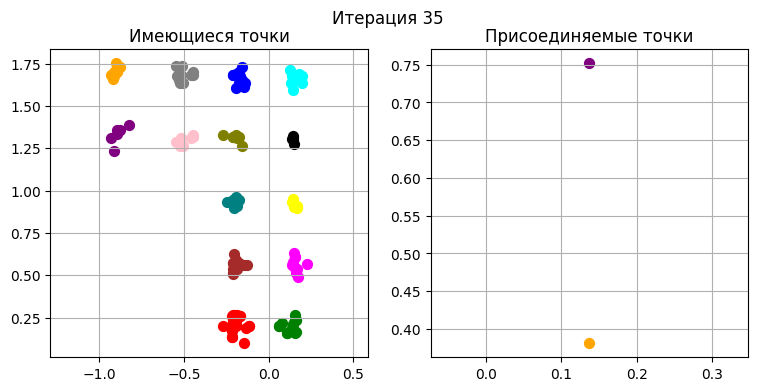

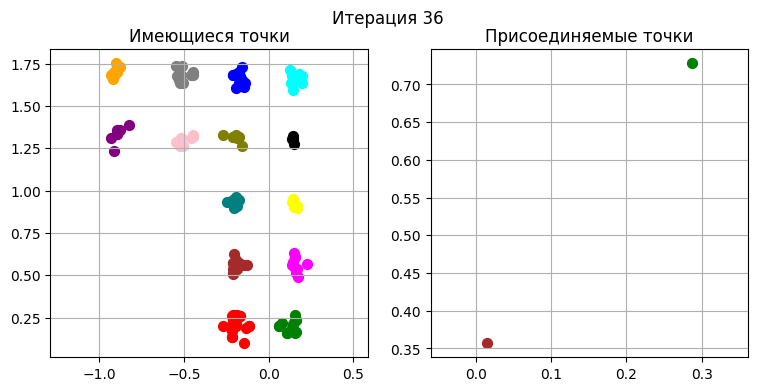

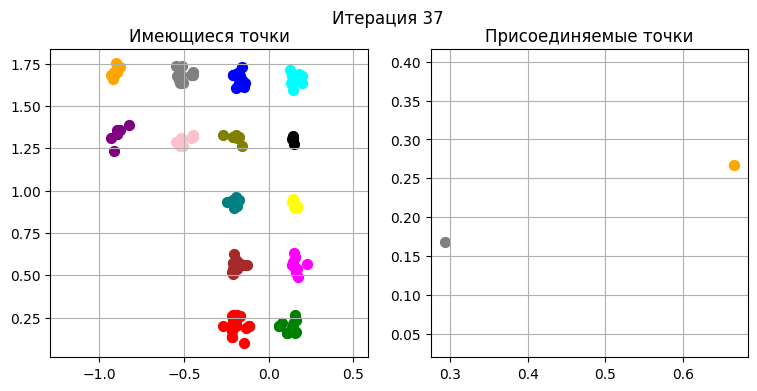

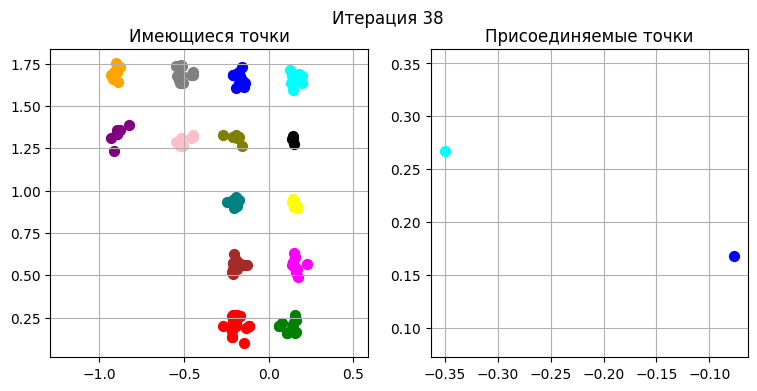

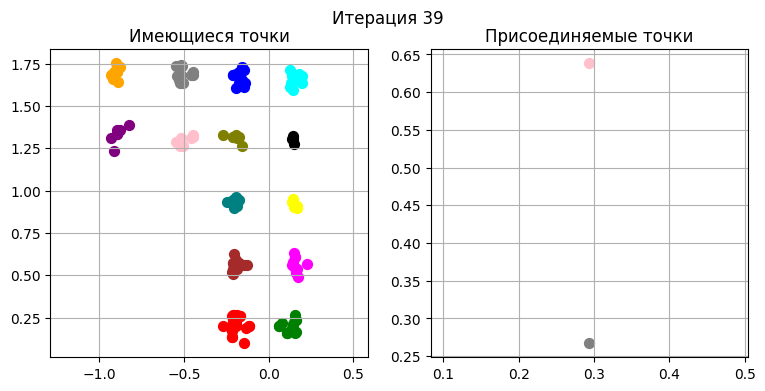

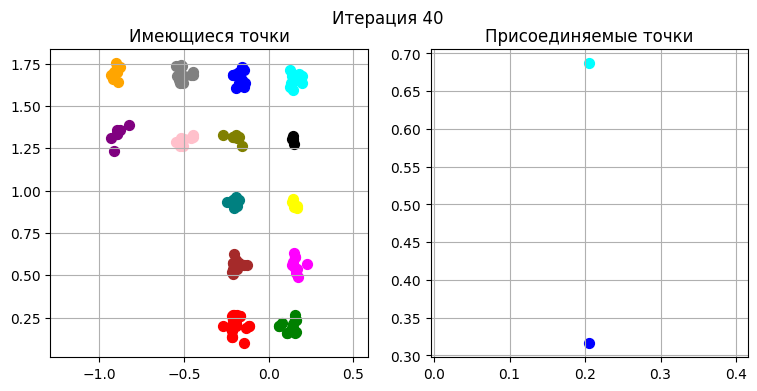

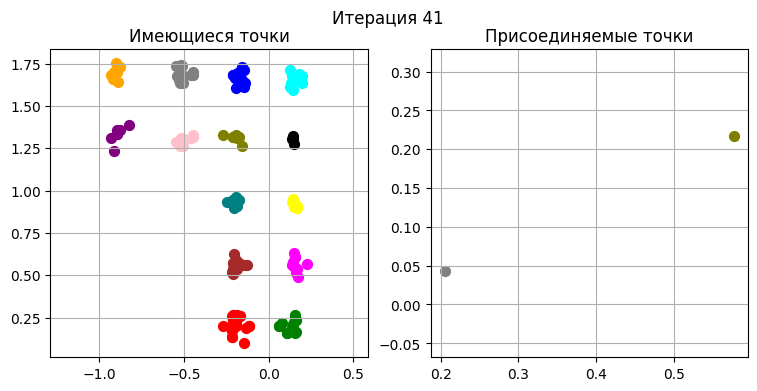

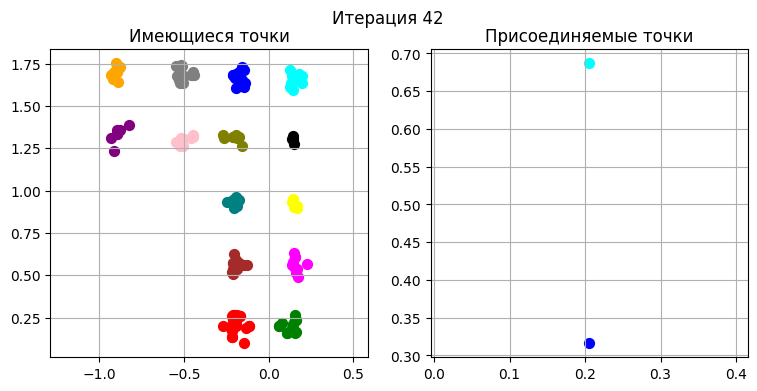

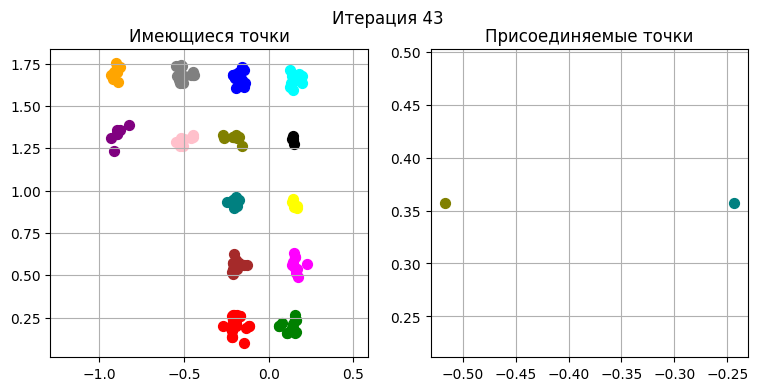

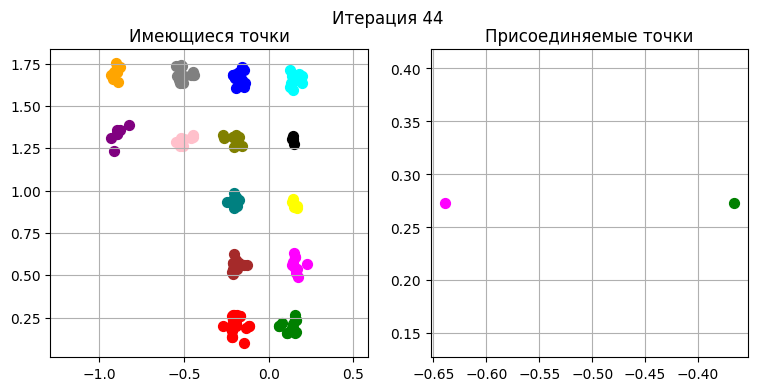

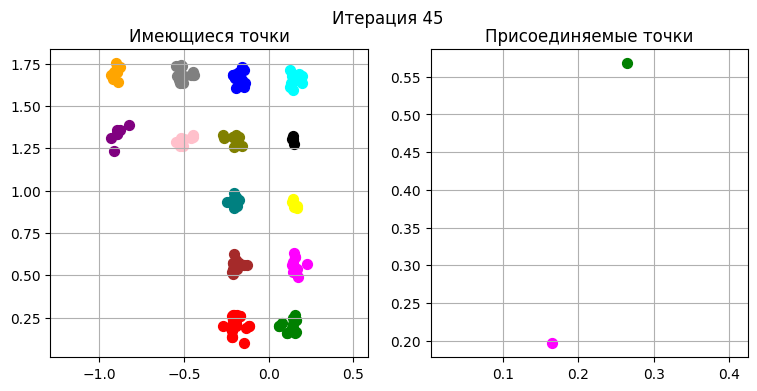

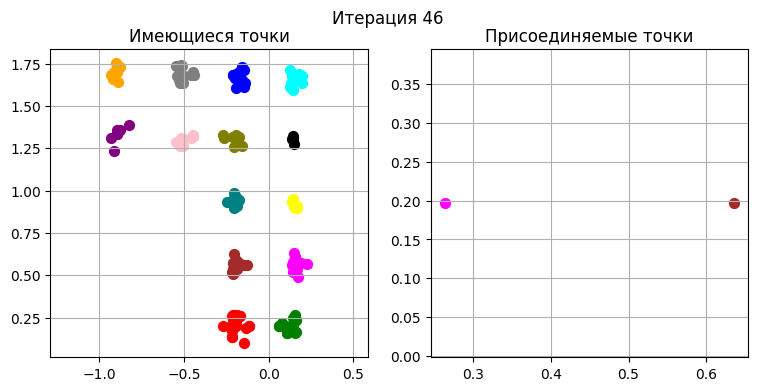

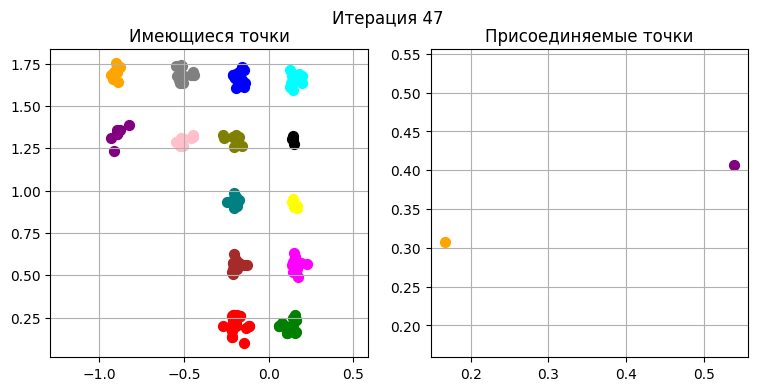

Конец поиска 47


In [130]:
for q in tqdm(range(int(1e5))):

    # Опредление индекса элемента у которого больше всего совпадений с основой
    next_view = -1
    max_match = -1
    for v in range(view_count):
        if v not in yet:
            v_set = set(view_labels[v])
            g_list = []
            for k in great_dict.keys():
                if len(great_dict[k]) > 0:
                    g_list += [k]
            g_set = set(g_list)
            mc = len(v_set & g_set)
            if mc > max_match and mc > 1:
                max_match = mc
                next_view = v
    if next_view == -1:
        print('Конец поиска', q)
        break
    yet += [next_view]

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    for la, po in great_dict.items():
        if len(po) == 0:
            continue
        pto = np.array(po)
        ax[0].scatter(pto[:, 0], pto[:, 1], color=colors[la], s=50)
    ax[0].grid(True)
    ax[0].axis('equal')
    ax[0].set_title(f'Имеющиеся точки')

    for i, la in enumerate(view_labels[next_view]):
        pto = coords[views == next_view][i:i+1, :2]
        ax[1].scatter(pto[:, 0], pto[:, 1], color=colors[la], s=50)
    ax[1].grid(True)
    ax[1].axis('equal')
    ax[1].set_title(f'Присоединяемые точки')
    fig.suptitle(f'Итерация {q+1}')
    plt.show()

    # Трансляция второго вида
    great_labels, great_coords = from_great(great_dict)
    s_params, s_dict = orient(great_labels, view_labels[next_view], great_coords, coords[views == next_view][:, :2])

    view_params[next_view] = s_params
    add_great(great_dict, s_dict)

In [96]:
great_dict

{0: [array([-0.19213867,  0.2006836 ], dtype=float32)],
 1: [],
 2: [array([-0.19213867,  1.6855469 ], dtype=float32)],
 3: [array([0.17907715, 1.6855469 ], dtype=float32)],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [array([-0.19213867,  0.57177734], dtype=float32)],
 11: [],
 12: [array([-0.19213867,  1.3144531 ], dtype=float32)],
 13: [array([-0.19213867,  0.9428711 ], dtype=float32)]}

In [90]:
coords[views == 50]

array([[0.26416016, 0.1965332 , 0.1973877 , 0.1973877 ],
       [0.6352539 , 0.1965332 , 0.1973877 , 0.1973877 ]], dtype=float32)

In [89]:
next_view

-1

In [85]:
view_labels[next_view]

[11, 9, 8]

In [51]:
def cluster_and_reposition(points, eps=0.05, min_samples=1):
    points = points.copy()

    x_coords = points[:, 0].reshape(-1, 1)
    y_coords = points[:, 1].reshape(-1, 1)
    
    db_x = DBSCAN(eps=eps, min_samples=1).fit(x_coords)
    db_y = DBSCAN(eps=eps, min_samples=1).fit(y_coords)
    
    labels_x = db_x.labels_
    labels_y = db_y.labels_

    x_c = {}
    for l in np.unique(labels_x):
        x_c[l] = points[labels_x==l][:, 0].mean(axis=0)
    y_c = {}
    for l in np.unique(labels_y):
        y_c[l] = points[labels_y==l][:, 1].mean(axis=0)
        
    for i in range(len(points)):
        points[i, 0] = x_c[labels_x[i]]
        points[i, 1] = y_c[labels_y[i]]

    return points

In [131]:
points = from_great(great_dict)[1]

In [73]:
colors = [
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'yellow',
    'black',
    'gray',
    'orange',
    'purple',
    'brown',
    'pink',
    'olive',
    'teal'
]

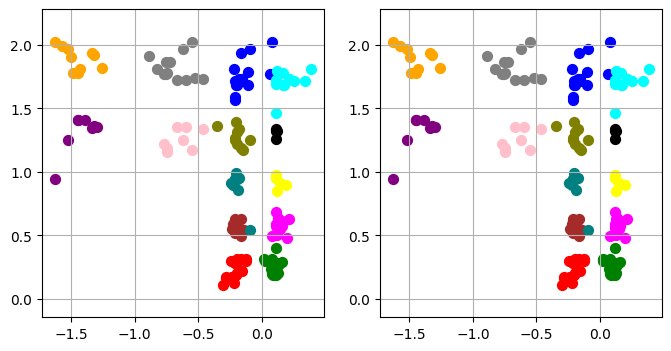

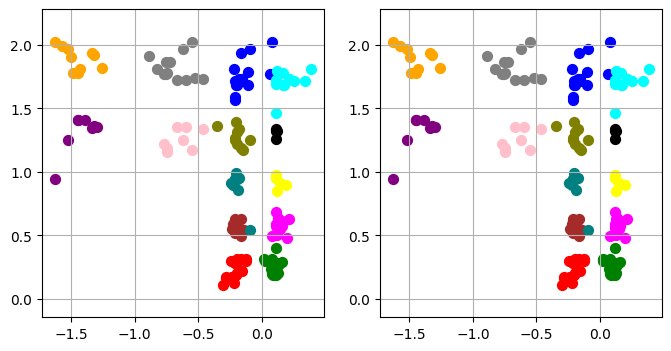

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for la, po in great_dict.items():
    pto = np.array(po)
    ax[0].scatter(pto[:, 0], pto[:, 1], color=colors[la], s=50)
ax[0].grid(True)
ax[0].axis('equal')

for la, po in great_dict.items():
    pto = np.array(po)
    ax[1].scatter(pto[:, 0], pto[:, 1], color=colors[la], s=50)
ax[1].grid(True)
ax[1].axis('equal')
plt.show()

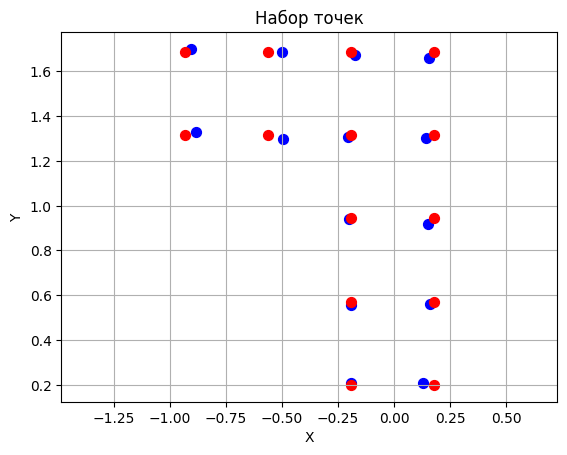

In [132]:
plt.scatter(points[:, 0], points[:, 1], color='blue', s=50)
plt.scatter(bbox_target[great_view, :14, :2][:, 0], bbox_target[great_view, :14, :2][:, 1], color='red', s=50)
plt.title("Набор точек")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis('equal')  # одинаковый масштаб по осям
plt.show()

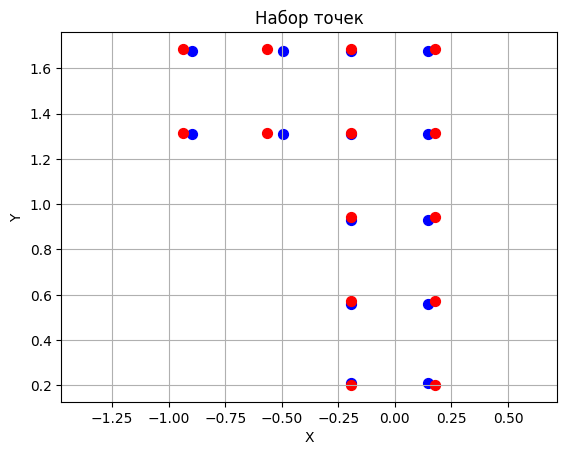

In [133]:
new_points = cluster_and_reposition(points, eps=0.15)

plt.scatter(new_points[:, 0], new_points[:, 1], color='blue', s=50)
plt.scatter(bbox_target[great_view, :14, :2][:, 0], bbox_target[great_view, :14, :2][:, 1], color='red', s=50)
plt.title("Набор точек")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis('equal')  # одинаковый масштаб по осям
plt.show()

In [134]:
great_bbox_dict = {k: [] for k in great_dict.keys()}
for view in range(house_fites[views_masks].shape[0]):
    if view_params[view] is not None:
        real_boxes = house_fites[views_masks][view][house_masks[views_masks][view]][:, 2:4]
        real_labels = view_labels[view]
        for i, l in enumerate(real_labels):
            if view_params[view][0] in [0, 180]:
                great_bbox_dict[l] += [real_boxes[i].numpy()*view_params[view][1]]
            elif view_params[view][0] in [90, 270]:
                great_bbox_dict[l] += [real_boxes[i].numpy()[::-1]*view_params[view][1]]

In [135]:
box_labels, box_dims = from_bbox(great_bbox_dict)

In [136]:
boxes = np.concatenate([new_points, box_dims], axis=1)

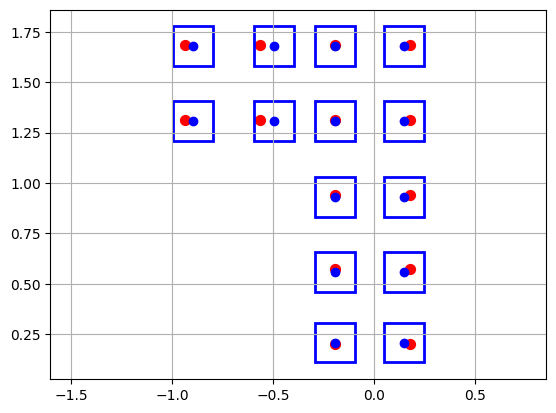

In [137]:
def from_bbox(great_bbox_dict, t=0.05):
    labels = []
    coords = []
    for k, i in great_bbox_dict.items():
        if len(i) > 0:
            labels += [k]
            lab_points = np.stack(i)
            x = lab_points[:,0]
            y = lab_points[:,1]
            x = x[x>t]
            y = y[y>t]
            mean_point = [x.mean() if len(x)>0 else 0, y.mean() if len(y)>0 else 0]
            coords += [mean_point]
    coords = np.stack(coords)
    return labels, coords

def visualize_boxes(boxes, color='blue', show_center=True):
    fig, ax = plt.subplots()
    ax.scatter(bbox_target[great_view, :14, :2][:, 0], bbox_target[great_view, :14, :2][:, 1], color='red', s=50)
    for box in boxes:
        cx, cy, w, h = box
        x = cx - w / 2
        y = cy - h / 2
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if show_center:
            ax.plot(cx, cy, 'bo')
    ax.set_aspect('equal')
    ax.autoscale()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

visualize_boxes(boxes)